In [28]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os
from collections import defaultdict
import zipfile
import umap
import re
import scipy.io
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [6]:
filename = r'V:\Ca_imaging_pain\4_fluorescence_traces\JH_322_raw_deltaF_over_F.mat'

with h5py.File(filename, 'r') as file:
    print(list(file.keys()))

['#refs#', 'dFF']


In [18]:
with h5py.File(filename, 'r') as file:
    # Access the 'dFF' cell array
    dff = file['dFF']

    # Specify the cell indices you want to access, e.g., (row, column)
    row_index = 0  # Assuming you want the first row
    col_index = 1  # Assuming you want the second column

    # Get the HDF5 reference for the specific cell
    ref = dff[row_index, col_index]

    # Dereference to get the data
    data = np.array(file[ref])

    # Now, 'data' contains the contents of the specified cell
    print(data)


[[-0.22213796]
 [-0.21399613]
 [-0.13897477]
 ...
 [-0.0843081 ]
 [-0.09070528]
 [-0.06453504]]


In [19]:
data.shape

(8925, 1)

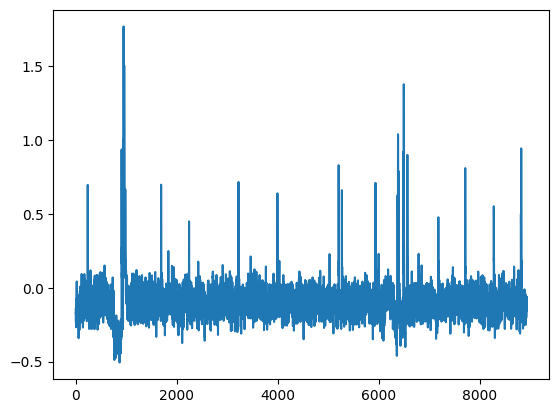

In [21]:
plt.plot(data)

## Step 2: Load the Data

In [26]:
path_to_extracted_folder = 'D:/deeplabcut/BSOID/'
data_files = os.listdir(path_to_extracted_folder)
saline_files = [file for file in data_files if any(mouse in file for mouse in ['322', '328', '330', '332'])]
pfa_files = [file for file in data_files if any(mouse in file for mouse in ['326', '327', '334', '335', '336'])]

saline_dataframes = [pd.read_csv('D:/deeplabcut/BSOID/' + file, header=[1,2]) for file in saline_files]
pfa_dataframes = [pd.read_csv('D:/deeplabcut/BSOID/' + file, header=[1,2]) for file in pfa_files]

saline_dataframes_cropped = saline_dataframes
pfa_dataframes_cropped = pfa_dataframes

frame_info_df_manual = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_led_frames.csv')
for f in range(len(saline_dataframes)):
    shape = saline_dataframes_cropped[f].shape[0]
    print(f"The number of rows in saline_dataframes[{f}] is {shape}")
for f in range(len(pfa_dataframes)):
    shape = pfa_dataframes_cropped[f].shape[0]
    print(f"The number of rows in pfa_dataframes[{f}] is {shape}")


The number of rows in saline_dataframes[0] is 64368
The number of rows in saline_dataframes[1] is 54470
The number of rows in saline_dataframes[2] is 60105
The number of rows in saline_dataframes[3] is 56312
The number of rows in saline_dataframes[4] is 67886
The number of rows in saline_dataframes[5] is 62965
The number of rows in saline_dataframes[6] is 61075
The number of rows in saline_dataframes[7] is 57337
The number of rows in pfa_dataframes[0] is 56475
The number of rows in pfa_dataframes[1] is 55362
The number of rows in pfa_dataframes[2] is 55763
The number of rows in pfa_dataframes[3] is 54637
The number of rows in pfa_dataframes[4] is 59808
The number of rows in pfa_dataframes[5] is 55038
The number of rows in pfa_dataframes[6] is 60014
The number of rows in pfa_dataframes[7] is 54855
The number of rows in pfa_dataframes[8] is 65294
The number of rows in pfa_dataframes[9] is 60233


In [36]:
def crop_dataframe(df, file_name):
    # Adjust the logic here to correctly extract the mouse name
    parts = file_name.split('DLC')
    mouse_name = parts[0].split('Hz')[1].rstrip('_')  # This should correctly extract the mouse name

    # Now, find the start frame
    start_frame = frame_info_df_manual[frame_info_df_manual['Filename'] == mouse_name]['Start'].values[0]
    return df.iloc[start_frame : start_frame + 53250]

saline_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(saline_dataframes, saline_files)]
pfa_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(pfa_dataframes, pfa_files)]
for f in range(len(saline_dataframes)):
    shape = saline_dataframes_cropped[f].shape[0]
    print(f"The number of rows in saline_dataframes[{f}] is {shape}")
for f in range(len(pfa_dataframes)):
    shape = pfa_dataframes_cropped[f].shape[0]
    print(f"The number of rows in pfa_dataframes[{f}] is {shape}")

The number of rows in saline_dataframes[0] is 53250
The number of rows in saline_dataframes[1] is 53250
The number of rows in saline_dataframes[2] is 53250
The number of rows in saline_dataframes[3] is 53250
The number of rows in saline_dataframes[4] is 53250
The number of rows in saline_dataframes[5] is 53250
The number of rows in saline_dataframes[6] is 53250
The number of rows in saline_dataframes[7] is 53250
The number of rows in pfa_dataframes[0] is 53250
The number of rows in pfa_dataframes[1] is 53250
The number of rows in pfa_dataframes[2] is 53250
The number of rows in pfa_dataframes[3] is 53250
The number of rows in pfa_dataframes[4] is 53250
The number of rows in pfa_dataframes[5] is 53250
The number of rows in pfa_dataframes[6] is 53250
The number of rows in pfa_dataframes[7] is 53250
The number of rows in pfa_dataframes[8] is 53250
The number of rows in pfa_dataframes[9] is 53250


In [37]:
def clean_data_modified(df):
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Replace missing values or NaN with interpolation on the copy
    df_copy.interpolate(method='linear', inplace=True, limit_direction='both')
    
    return df_copy

# Applying the modified function to the cropped dataframes
saline_dataframes_cleaned = [clean_data_modified(df) for df in saline_dataframes_cropped]
pfa_dataframes_cleaned = [clean_data_modified(df) for df in pfa_dataframes_cropped]
downsampled_saline_dataframes = [df.iloc[::6] for df in saline_dataframes_cleaned]
downsampled_pfa_dataframes = [df.iloc[::6] for df in pfa_dataframes_cleaned]


In [38]:
downsampled_saline_dataframes

[           0  19 bodyparts miniscope_head                              snout   
            1  19    coords              x           y likelihood           x   
 8576    8578   2      8576     841.260864  387.321960   1.000000  862.359436  \
 8582    8584   2      8582     840.709351  387.061798   1.000000  861.713318   
 8588    8590   2      8588     840.687500  387.480011   1.000000  862.283691   
 8594    8596   2      8594     840.494019  386.653198   1.000000  862.096985   
 8600    8602   2      8600     840.662292  386.984711   1.000000  862.068848   
 ...      ...  ..       ...            ...         ...        ...         ...   
 61796  61798  33     61796     641.510864  204.171265   0.999998  626.146973   
 61802  61804  33     61802     674.117371  225.203659   1.000000  656.292297   
 61808  61810  33     61808     711.013062  211.506180   1.000000  683.160645   
 61814  61816  33     61814     755.572876  209.853500   1.000000  726.966370   
 61820  61822  33     61820 

## connect the data with BSOID

In [163]:
def group_indices_by_label(df):
    indices_groups = defaultdict(list)
    # Accessing the second column by its position
    labels = df.iloc[:, 1].tolist()
    for i, label in enumerate(labels):
        indices_groups[label].append(i)
    return indices_groups

# Example usage
indices_groups_list = []
for df in downsampled_pfa_dataframes:
    indices_groups = group_indices_by_label(df)
    indices_groups_list.append(indices_groups)

# 'indices_groups_list' now contains the indices grouped by labels for each DataFrame


In [170]:
# Assuming 'df' is your DataFrame and 'indices_groups' is the dictionary with indices
file_of_interest =5  # This is the label you're interested in
indices_for_label = indices_groups_list[file_of_interest][24]
indices_for_label

[5497,
 7866,
 7867,
 7868,
 7869,
 7870,
 7871,
 7872,
 7873,
 7874,
 7875,
 7876,
 7877,
 7878,
 7879,
 7880,
 7881,
 7882,
 7883,
 7884,
 7885,
 7886,
 7887,
 7888,
 7889,
 7890,
 7891,
 7892,
 7893,
 7894,
 7895,
 7896,
 7897,
 7898,
 7899,
 7900,
 7901,
 7902,
 7903,
 7904,
 7905,
 7906,
 7907,
 7972,
 7973,
 7974,
 7975,
 7976,
 7977,
 7978,
 7979,
 7980,
 7981,
 7982,
 7983,
 7984,
 7985,
 7986,
 7987,
 7988,
 7989,
 7990,
 7991,
 7992,
 7993,
 7994,
 7995,
 7996,
 7997,
 7998,
 7999,
 8000,
 8001,
 8002,
 8003,
 8004,
 8005,
 8006,
 8007,
 8008,
 8009,
 8010,
 8011,
 8012,
 8013,
 8014,
 8015,
 8016,
 8017,
 8018,
 8019,
 8020,
 8021,
 8022,
 8023,
 8024,
 8025,
 8026,
 8027,
 8028,
 8029,
 8032,
 8034,
 8035,
 8041,
 8042,
 8043,
 8044,
 8134,
 8135,
 8136,
 8137,
 8138,
 8139,
 8140,
 8141,
 8142,
 8143,
 8144,
 8145,
 8146,
 8147,
 8148,
 8149,
 8150,
 8151,
 8152,
 8153,
 8154,
 8155,
 8156,
 8157,
 8158,
 8159,
 8160,
 8161,
 8162,
 8163,
 8164,
 8165,
 8166,
 8167,
 8168,

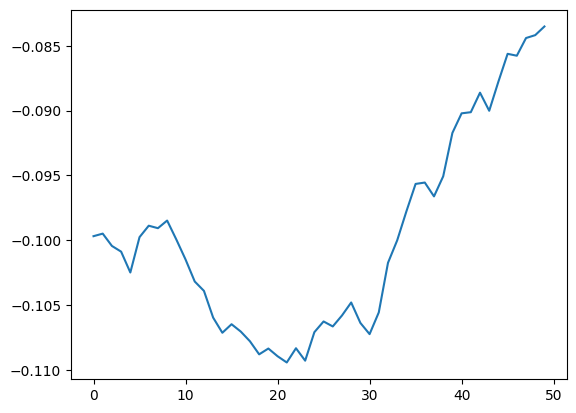

In [171]:
data_slices = []
SR = 5
sec = SR* 5
for i in indices_for_label:
    if (i - sec) < 0 or (i + sec) > len(data):
        # Skip if the range goes out of the data bounds
        continue
    data_slices.append(data[i-sec:i+sec])

# Convert the list of slices into a 2D NumPy array for easier calculation
data_array = np.array(data_slices)

# Calculate the average trace
avg_trace = np.mean(data_array, axis=0)

# Plot the average trace
plt.plot(avg_trace)
plt.show()

In [153]:
data[0]

array([-0.22213796])